In [1]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from os import listdir
from os.path import isfile, join
from PIL import Image
import glob


seed = 2019
np.random.seed(seed)
%matplotlib inline

In [2]:
tf.__version__

'2.1.0-rc0'

# Path sets

In [3]:
Training_kaggle = True

In [4]:
if  Training_kaggle==True:
    dirname = '/kaggle/input'
    train_path = os.path.join(dirname, 'chest-xray-pneumonia/chest_xray/chest_xray/train')
    train_nrml_pth = os.path.join(train_path, 'NORMAL')
    train_pnm_pth = os.path.join(train_path, 'PNEUMONIA')
    test_path = os.path.join(dirname, 'chest-xray-pneumonia/chest_xray/chest_xray/test')
    test_nrml_pth = os.path.join(test_path, 'NORMAL')
    test_pnm_pth = os.path.join(test_path, 'PNEUMONIA')
    val_path = os.path.join(dirname, 'chest-xray-pneumonia/chest_xray/chest_xray/test')
    val_nrml_pth = os.path.join(val_path, 'NORMAL')
    val_pnm_pth = os.path.join(val_path, 'PNEUMONIA')
else:
    dirname = ''
    train_path = os.path.join(dirname, '../input/chest_xray/train/')
    train_nrml_pth = os.path.join(train_path, 'NORMAL')
    train_pnm_pth = os.path.join(train_path, 'PNEUMONIA')
    test_path = os.path.join(dirname, '../input/chest_xray/test/')
    test_nrml_pth = os.path.join(test_path, 'NORMAL')
    test_pnm_pth = os.path.join(test_path, 'PNEUMONIA')
    val_path = os.path.join(dirname, '../input/chest_xray/val/')
    val_nrml_pth = os.path.join(val_path, 'NORMAL')
    val_pnm_pth = os.path.join(val_path, 'PNEUMONIA')

In [5]:
train_nrml_pth

'/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL'

# Let's see what xray photos look like

In [6]:
def plot_imgs(item_dir, num_imgs=6):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs]

    plt.figure(figsize=(20, 12))
    for idx, img_path in enumerate(item_files):
        plt.subplot(2, 3, idx+1)

        img = plt.imread(img_path)
        plt.imshow(img, cmap='gray')

    plt.tight_layout()

### Normal

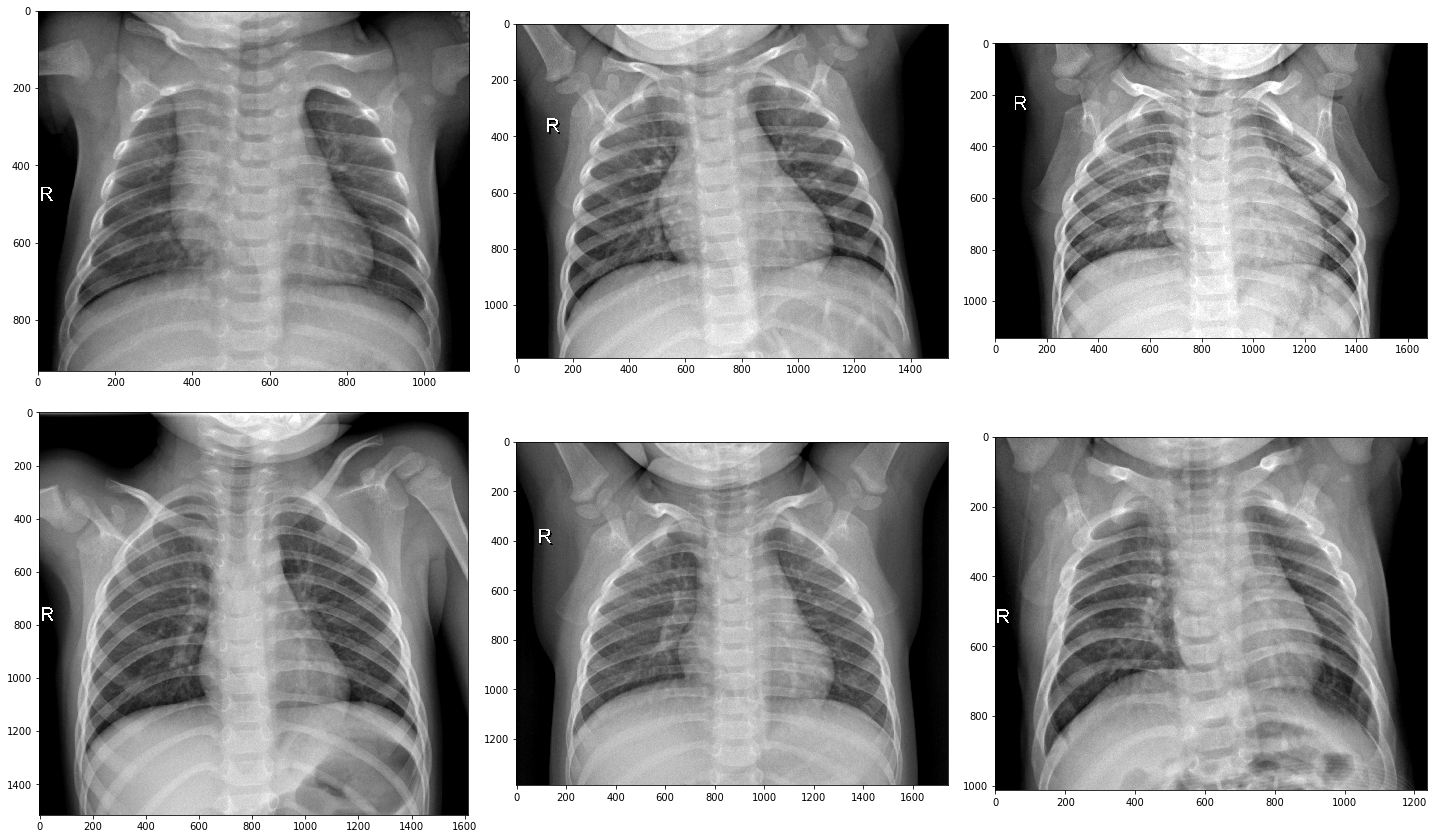

In [7]:
plot_imgs(train_nrml_pth)

### Pneumonia

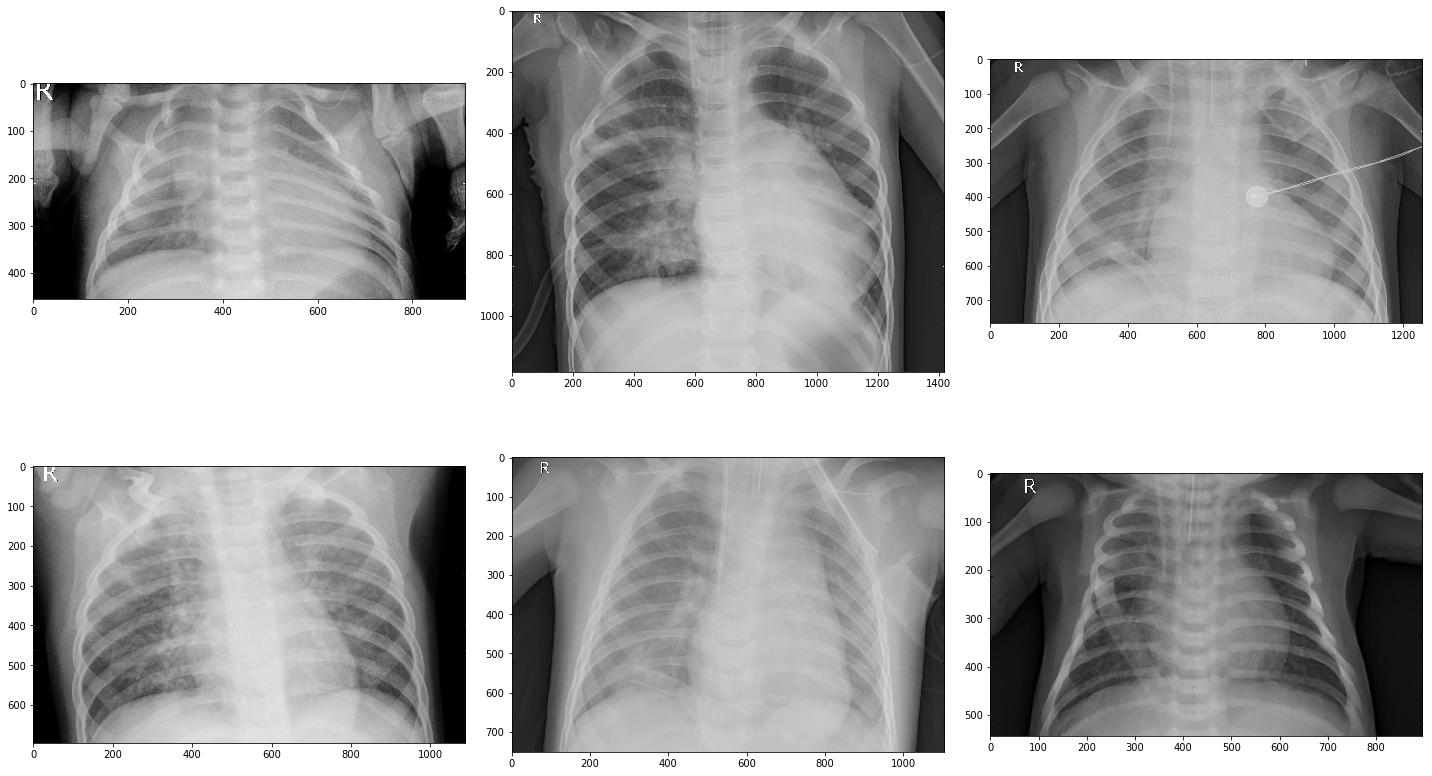

In [8]:
plot_imgs(train_pnm_pth)

# Details about images dimensions

In [9]:
def Images_details_Print_data(data, path):
    print(" ====== Images in: ", path)    
    for k, v in data.items():
        print("%s:\t%s" % (k, v))

def Images_details(path):
    files = [f for f in glob.glob(path + "**/*.*", recursive=True)]
    data = {}
    data['images_count'] = len(files)
    data['min_width'] = 10**100  # No image will be bigger than that
    data['max_width'] = 0
    data['min_height'] = 10**100  # No image will be bigger than that
    data['max_height'] = 0


    for f in files:
        im = Image.open(f)
        width, height = im.size
        data['min_width'] = min(width, data['min_width'])
        data['max_width'] = max(width, data['max_height'])
        data['min_height'] = min(height, data['min_height'])
        data['max_height'] = max(height, data['max_height'])

    Images_details_Print_data(data, path)


In [10]:
Images_details(train_nrml_pth)
Images_details(train_pnm_pth)

 ====== Images in:  /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL
images_count:	1341
min_width:	912
max_width:	2663
min_height:	672
max_height:	2663
 ====== Images in:  /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA
images_count:	3875
min_width:	384
max_width:	2304
min_height:	127
max_height:	2304


In [11]:
Images_details(test_nrml_pth)
Images_details(test_pnm_pth)

 ====== Images in:  /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL
images_count:	234
min_width:	984
max_width:	2713
min_height:	496
max_height:	2713
 ====== Images in:  /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA
images_count:	390
min_width:	728
max_width:	1456
min_height:	344
max_height:	1456


In [12]:
Images_details(val_nrml_pth)
Images_details(val_pnm_pth)

 ====== Images in:  /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL
images_count:	234
min_width:	984
max_width:	2713
min_height:	496
max_height:	2713
 ====== Images in:  /kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test/PNEUMONIA
images_count:	390
min_width:	728
max_width:	1456
min_height:	344
max_height:	1456


In [13]:
if  Training_kaggle==True:
    input_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/"
else:
    input_path = "../input/chest_xray/"
    
for _set in ['train', 'test', 'val']:
    nrml = len(os.listdir(input_path + _set + '/NORMAL'))
    pnm = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('{}, Normal images: {}, Pneumonia images: {}'.format(_set, nrml, pnm))

train, Normal images: 1342, Pneumonia images: 3876
test, Normal images: 234, Pneumonia images: 390
val, Normal images: 9, Pneumonia images: 9


# Data augmentation
The practice of data augmentation is an effective way to increase the size of the training set.

Augmenting the training examples allow the network to “see” more diversified, but still representative, data points during training.

There's two data generators: one for training data, and the other for validation data. 
A data generator is capable of loading the required amount of data (a mini batch of images) directly from the source folder, convert them into training data (fed to the model) and training targets (a vector of attributes — the supervision signal).

In [14]:
def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(
        rescale = 1./255,
      #  featurewise_center=True,
      #  featurewise_std_normalization=True,
        zoom_range = 0.3,
        vertical_flip = True)
    
    test_datagen = ImageDataGenerator(
      #  featurewise_center=True,
      #  featurewise_std_normalization=True,
        rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory = train_path, 
    target_size = (img_dims, img_dims), 
    batch_size = batch_size, 
    class_mode = 'binary', 
    shuffle=True)

    test_gen = test_datagen.flow_from_directory(
    directory=test_path, 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(test_path + cond)):
            img = plt.imread(test_path + cond + img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

# Network - some theory at first

**Some theory about Spatial Separable Convolutions.**

Conceptually, this is the easier one out of the two, and illustrates the idea of separating one convolution into two well, so I’ll start with this. Unfortunately, spatial separable convolutions have some significant limitations, meaning that it is not heavily used in deep learning.

The spatial separable convolution is so named because it deals primarily with the spatial dimensions of an image and kernel: the width and the height. (The other dimension, the “depth” dimension, is the number of channels of each image).
A spatial separable convolution simply divides a kernel into two, smaller kernels.

The most common case would be to divide a 3x3 kernel into a 3x1 and 1x3 kernel, like so:

<img src="https://miro.medium.com/max/1135/1*mL53fW0tJpNWEePp54y1Sg.png" width="50%">

Now, instead of doing one convolution with 9 multiplications, we do two convolutions with 3 multiplications each (6 in total) to achieve the same effect. With less multiplications, computational complexity goes down, and the network is able to run faster.

<img src="https://miro.medium.com/max/1238/1*o3mKhG3nHS-1dWa_plCeFw.png" width="50%">

One of the most famous convolutions that can be separated spatially is the Sobel kernel, used to detect edges:

<img src="https://miro.medium.com/max/1144/1*r4MjVvb2rehlIzpTKZdhcA.png" width="50%">

The main issue with the spatial separable convolution is that not all kernels can be “separated” into two, smaller kernels. This becomes particularly bothersome during training, since of all the possible kernels the network could have adopted, it can only end up using one of the tiny portion that can be separated into two smaller kernels.

**Depthwise Separable Convolutions**

Unlike spatial separable convolutions, depthwise separable convolutions work with kernels that cannot be “factored” into two smaller kernels. Hence, it is more commonly used. This is the type of separable convolution seen in keras.layers.SeparableConv2D or tf.layers.separable_conv2d.

The depthwise separable convolution is so named because it deals not just with the spatial dimensions, but with the depth dimension — the number of channels — as well. An input image may have 3 channels: RGB. After a few convolutions, an image may have multiple channels. You can image each channel as a particular interpretation of that image; in for example, the “red” channel interprets the “redness” of each pixel, the “blue” channel interprets the “blueness” of each pixel, and the “green” channel interprets the “greenness” of each pixel. An image with 64 channels has 64 different interpretations of that image.


Similar to the spatial separable convolution, a depthwise separable convolution splits a kernel into 2 separate kernels that do two convolutions: the depthwise convolution and the pointwise convolution. But first of all, let’s see how a normal convolution works.

*Normal Convolution:*

If you don’t know how a convolution works from a 2-D perspective, read this article or check out this site.
A typical image, however, is not 2-D; it also has depth as well as width and height. Let us assume that we have an input image of 12x12x3 pixels, an RGB image of size 12x12.
Let’s do a 5x5 convolution on the image with no padding and a stride of 1. If we only consider the width and height of the image, the convolution process is kind of like this: 12x12 — (5x5) — >8x8. The 5x5 kernel undergoes scalar multiplication with every 25 pixels, giving out1 number every time. We end up with a 8x8 pixel image, since there is no padding (12–5+1 = 8).

However, because the image has 3 channels, our convolutional kernel needs to have 3 channels as well. This means, instead of doing 5x5=25 multiplications, we actually do 5x5x3=75 multiplications every time the kernel moves.
Just like the 2-D interpretation, we do scalar matrix multiplication on every 25 pixels, outputting 1 number. After going through a 5x5x3 kernel, the 12x12x3 image will become a 8x8x1 image.

<img src="https://miro.medium.com/max/1218/1*fgYepSWdgywsqorf3bdksg.png" width="80%">

What if we want to increase the number of channels in our output image? What if we want an output of size 8x8x256?
Well, we can create 256 kernels to create 256 8x8x1 images, then stack them up together to create a 8x8x256 image output.

<img src="https://miro.medium.com/max/1447/1*XloAmCh5bwE4j1G7yk5THw.png" width="80%">

his is how a normal convolution works. I like to think of it like a function: 12x12x3 — (5x5x3x256) — >12x12x256 (Where 5x5x3x256 represents the height, width, number of input channels, and number of output channels of the kernel). Not that this is not matrix multiplication; we’re not multiplying the whole image by the kernel, but moving the kernel through every part of the image and multiplying small parts of it separately.

A depthwise separable convolution separates this process into 2 parts: a depthwise convolution and a pointwise convolution.


*Part 1 — Depthwise Convolution:*

In the first part, depthwise convolution, we give the input image a convolution without changing the depth. We do so by using 3 kernels of shape 5x5x1.


<img src="https://miro.medium.com/max/1308/1*yG6z6ESzsRW-9q5F_neOsg.png" width="80%">
Each 5x5x1 kernel iterates 1 channel of the image (note: 1 channel, not all channels), getting the scalar products of every 25 pixel group, giving out a 8x8x1 image. Stacking these images together creates a 8x8x3 image.

*Part 2 — Pointwise Convolution:*

Remember, the original convolution transformed a 12x12x3 image to a 8x8x256 image. Currently, the depthwise convolution has transformed the 12x12x3 image to a 8x8x3 image. Now, we need to increase the number of channels of each image.

The pointwise convolution is so named because it uses a 1x1 kernel, or a kernel that iterates through every single point. This kernel has a depth of however many channels the input image has; in our case, 3. Therefore, we iterate a 1x1x3 kernel through our 8x8x3 image, to get a 8x8x1 image.

<img src="https://miro.medium.com/max/1222/1*37sVdBZZ9VK50pcAklh8AQ.png" width="80%">

We can create 256 1x1x3 kernels that output a 8x8x1 image each to get a final image of shape 8x8x256.

<img src="https://miro.medium.com/max/1407/1*Q7a20gyuunpJzXGnWayUDQ.png" width="80%">

And that’s it! We’ve separated the convolution into 2: a depthwise convolution and a pointwise convolution. In a more abstract way, if the original convolution function is 12x12x3 — (5x5x3x256) →12x12x256, we can illustrate this new convolution as 12x12x3 — (5x5x1x1) — > (1x1x3x256) — >12x12x256.


**Alright, but what’s the point of creating a depthwise separable convolution?**

Let’s calculate the number of multiplications the computer has to do in the original convolution. There are 256 5x5x3 kernels that move 8x8 times. That’s 256x3x5x5x8x8=1,228,800 multiplications.
What about the separable convolution? In the depthwise convolution, we have 3 5x5x1 kernels that move 8x8 times. That’s 3x5x5x8x8 = 4,800 multiplications. In the pointwise convolution, we have 256 1x1x3 kernels that move 8x8 times. That’s 256x1x1x3x8x8=49,152 multiplications. Adding them up together, that’s 53,952 multiplications.

52,952 is a lot less than 1,228,800. With less computations, the network is able to process more in a shorter amount of time.

How does that work, though? The first time I came across this explanation, it didn’t really make sense to me intuitively. Aren’t the two convolutions doing the same thing? In both cases, we pass the image through a 5x5 kernel, shrink it down to one channel, then expand it to 256 channels. How come one is more than twice as fast as the other?

After pondering about it for some time, I realized that the main difference is this: in the normal convolution, we are transforming the image 256 times. And every transformation uses up 5x5x3x8x8=4800 multiplications. In the separable convolution, we only really transform the image once — in the depthwise convolution. Then, we take the transformed image and simply elongate it to 256 channels. Without having to transform the image over and over again, we can save up on computational power.

It’s worth noting that in both Keras and Tensorflow, there is a argument called the “depth multiplier”. It is set to 1 at default. By changing this argument, we can change the number of output channels in the depthwise convolution. For example, if we set the depth multiplier to 2, each 5x5x1 kernel will give out an output image of 8x8x2, making the total (stacked) output of the depthwise convolution 8x8x6 instead of 8x8x3. Some may choose to manually set the depth multiplier to increase the number of parameters in their neural net for it to better learn more traits.

Are the disadvantages to a depthwise separable convolution? Definitely! Because it reduces the number of parameters in a convolution, if your network is already small, you might end up with too few parameters and your network might fail to properly learn during training. If used properly, however, it manages to enhance efficiency without significantly reducing effectiveness, which makes it a quite popular choice.

Author: Chi-Feng Wang



# Network architecture

In [15]:
# Hyperparameters
img_dims = 150
epochs = 20
batch_size = 32

# Getting the data
train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [16]:
inputs = Input(shape=(img_dims, img_dims, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 75, 75, 32)        688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 75, 75, 32)        1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 32)        128   

# Fitting the model

In [18]:
history = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, 
           validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size,
           callbacks=[checkpoint, lr_reduce])

Train for 163 steps, validate for 19 steps
Epoch 1/20
163/163 [==============================] - 103s 633ms/step - loss: 0.3613 - accuracy: 0.8298 - val_loss: 0.6900 - val_accuracy: 0.6184
Epoch 2/20
163/163 [==============================] - 98s 603ms/step - loss: 0.2808 - accuracy: 0.8785 - val_loss: 0.6698 - val_accuracy: 0.6184
Epoch 3/20
162/163 [============================>.] - ETA: 0s - loss: 0.2671 - accuracy: 0.8893
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 97s 597ms/step - loss: 0.2667 - accuracy: 0.8896 - val_loss: 0.6564 - val_accuracy: 0.6184
Epoch 4/20
163/163 [==============================] - 97s 596ms/step - loss: 0.2027 - accuracy: 0.9222 - val_loss: 1.4071 - val_accuracy: 0.6184
Epoch 5/20
163/163 [==============================] - 97s 595ms/step - loss: 0.2037 - accuracy: 0.9195 - val_loss: 0.2804 - val_accuracy: 0.8799
Epoch 6/20
162/163 [============================>.] - ETA: 0s - lo

# Plot learning curves

In [19]:
history.history

{'loss': [0.361250330471188,
  0.28077374805519184,
  0.26667610338769077,
  0.20267125047697612,
  0.20367324432255302,
  0.18806398079439174,
  0.1690023753312102,
  0.16351840581082128,
  0.16044885757739194,
  0.1532419991845185,
  0.15354512705027692,
  0.1517025348530408,
  0.15092165384190215,
  0.15827502233713317,
  0.14965829701145733,
  0.15300118006720134,
  0.1511917169794349,
  0.15227060273655355,
  0.15007299133376475,
  0.1493291947076474],
 'accuracy': [0.8297546,
  0.87845093,
  0.88957053,
  0.9221626,
  0.91947854,
  0.9256135,
  0.9327071,
  0.9380751,
  0.9398006,
  0.9453604,
  0.94095093,
  0.944977,
  0.94325155,
  0.94152606,
  0.9478528,
  0.94440186,
  0.9424847,
  0.9430598,
  0.943635,
  0.94440186],
 'val_loss': [0.6900042013118142,
  0.6697501320587961,
  0.656442055576726,
  1.4070997771463896,
  0.2804481057744277,
  0.33656005247643117,
  0.3282695796928908,
  0.30933105475024175,
  0.3229914531111717,
  0.26850563444589315,
  0.28654273599386215,
  

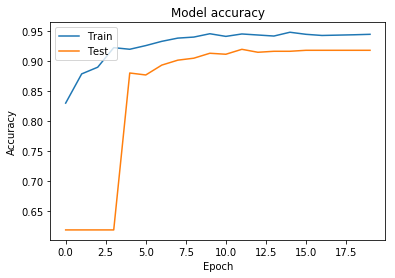

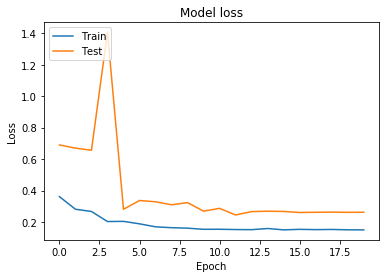

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Confusion Matrix

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((history.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[190  44]
 [  7 383]]

TEST METRICS ----------------------
Accuracy: 91.82692307692307%
Precision: 89.69555035128806%
Recall: 98.2051282051282%
F1-score: 93.7576499388005

TRAIN METRIC ----------------------
Train acc: 94.44


## Summary
The model is converging which can be observed from the decrease in loss and validation loss with epochs. Also it is able to reach over 90% validation accuracy in just 20 epochs.